In [1]:
# Imports and Setup
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib
matplotlib.use('Agg')  # Use Agg backend for matplotlib
import matplotlib.pyplot as plt
plt.switch_backend('Agg')  # Ensures non-GUI backend if only plt is imported

import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc

# Kaggle inline plotting
%matplotlib inline

# Set the seaborn style
sns.set(style='whitegrid')

# Display a note in the logs
print('Libraries imported and setup complete.')

Libraries imported and setup complete.


In [2]:
import os
import kagglehub
import pandas as pd

# Download the dataset (returns a directory path)
dataset_dir = kagglehub.dataset_download("architsharma01/loan-approval-prediction-dataset")
print("Path to dataset files:", dataset_dir)

# List all files in the dataset directory
files = os.listdir(dataset_dir)
print("Files found:", files)

# Find the first CSV file in the directory
csv_files = [f for f in files if f.endswith('.csv')]
if not csv_files:
    raise FileNotFoundError("No CSV file found in the dataset directory.")
else:
    csv_path = os.path.join(dataset_dir, csv_files[0])
    df = pd.read_csv(csv_path, encoding='ascii', delimiter=',')

    # A quick look at the data
    print('Dataset shape:', df.shape)
    print(df.head())


100%|██████████| 80.6k/80.6k [00:00<00:00, 527kB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/architsharma01/loan-approval-prediction-dataset/versions/1
Files found: ['loan_approval_dataset.csv']


Dataset shape: (4269, 13)
   loan_id   no_of_dependents      education  self_employed   income_annum  \
0        1                  2       Graduate             No        9600000   
1        2                  0   Not Graduate            Yes        4100000   
2        3                  3       Graduate             No        9100000   
3        4                  3       Graduate             No        8200000   
4        5                  5   Not Graduate            Yes        9800000   

    loan_amount   loan_term   cibil_score   residential_assets_value  \
0      29900000          12           778                    2400000   
1      12200000           8           417                    2700000   
2      29700000          20           506                    7100000   
3      30700000           8           467                   18200000   
4      24200000          20           382                   12400000   

    commercial_assets_value   luxury_assets_value   bank_asset_value  \


In [21]:
df.head(1)

,loan_id,dependents,education,self_employed,income_annual,loan_amount,loan_term,cibil_score,residential_value,commercial_value,luxury_value,bank_value,loan_status,loan_status_encoded
0,1,2,Graduate,No,9600000,29900000,12,778,2400000,17600000,22700000,8000000,Approved,0


In [12]:

df.head()

,loan_id,dependents,education,self_employed,income_annual,loan_amount,loan_term,cibil_score,residential_value,commercial_value,luxury_value,bank_value,loan_status,loan_status_encoded
0,1,2,Graduate,No,9600000,29900000,12,778,2400000,17600000,22700000,8000000,Approved,0
1,2,0,Not Graduate,Yes,4100000,12200000,8,417,2700000,2200000,8800000,3300000,Rejected,1
2,3,3,Graduate,No,9100000,29700000,20,506,7100000,4500000,33300000,12800000,Rejected,1
3,4,3,Graduate,No,8200000,30700000,8,467,18200000,3300000,23300000,7900000,Rejected,1
4,5,5,Not Graduate,Yes,9800000,24200000,20,382,12400000,8200000,29400000,5000000,Rejected,1


In [13]:
#Exploratory Data Analysis (EDA)

# Quick summary of the dataset
print(df.info())
print(df.describe())

# Since some column names have extra spaces, let's strip them
df.columns = df.columns.str.strip()

# Check for missing values
print('Missing values in each column:')
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4269 entries, 0 to 4268
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   loan_id              4269 non-null   int64 
 1   dependents           4269 non-null   int64 
 2   education            4269 non-null   object
 3   self_employed        4269 non-null   object
 4   income_annual        4269 non-null   int64 
 5   loan_amount          4269 non-null   int64 
 6   loan_term            4269 non-null   int64 
 7   cibil_score          4269 non-null   int64 
 8   residential_value    4269 non-null   int64 
 9   commercial_value     4269 non-null   int64 
 10  luxury_value         4269 non-null   int64 
 11  bank_value           4269 non-null   int64 
 12  loan_status          4269 non-null   object
 13  loan_status_encoded  4269 non-null   int64 
dtypes: int64(11), object(3)
memory usage: 467.1+ KB
None
           loan_id   dependents  income_annual   lo

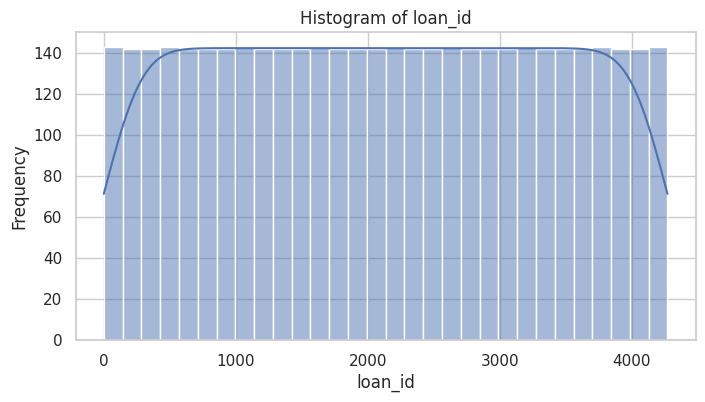

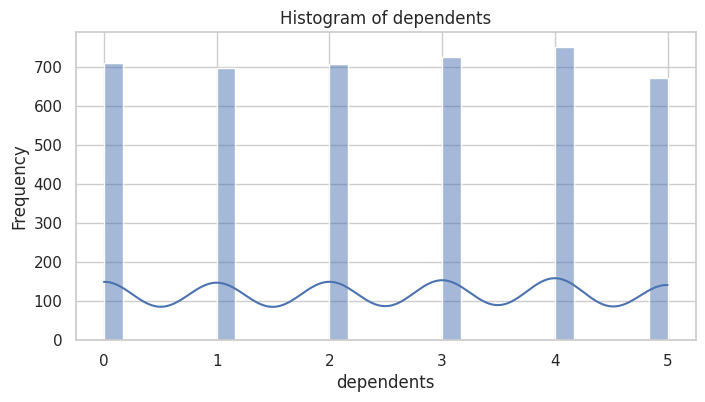

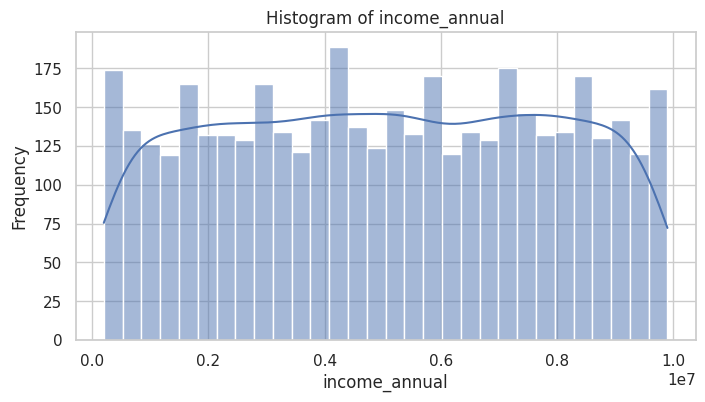

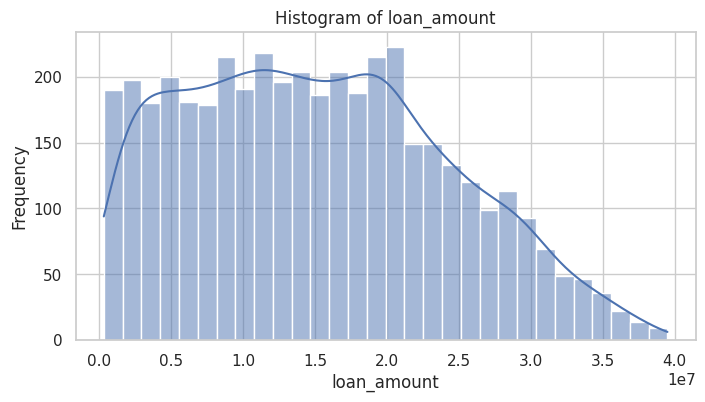

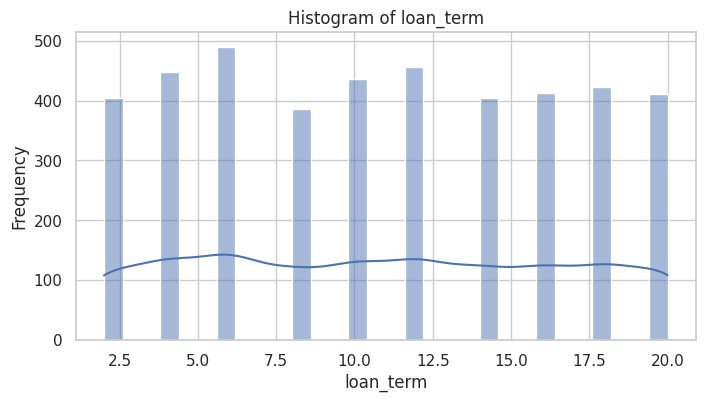

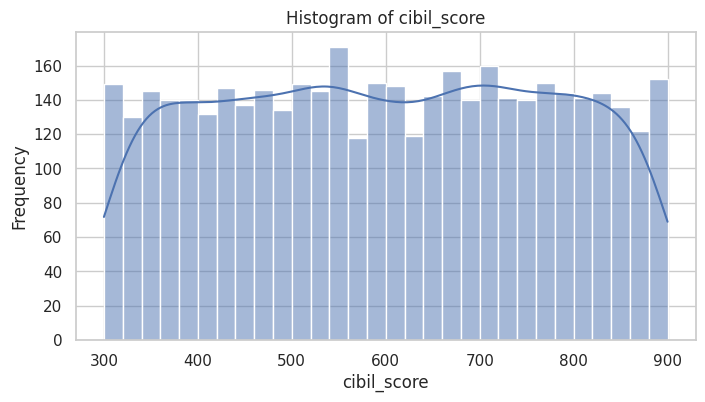

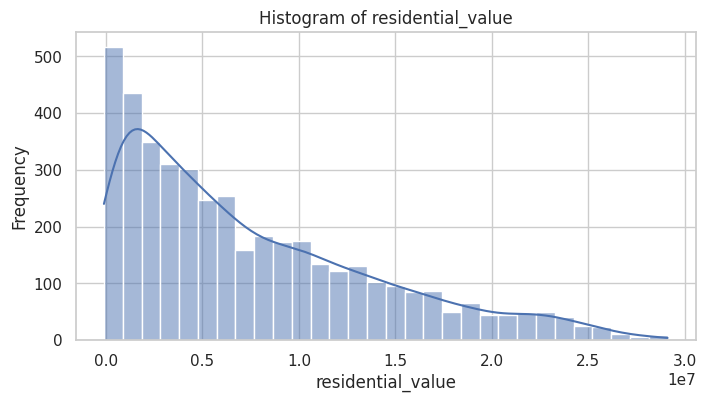

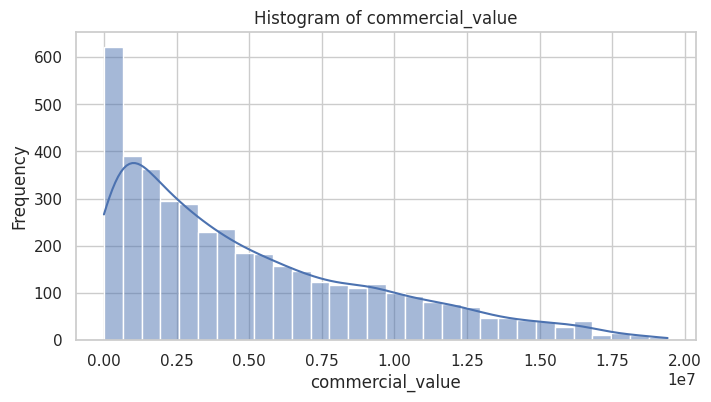

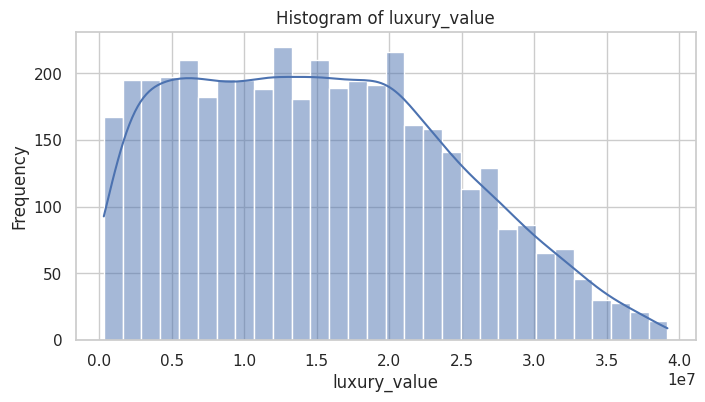

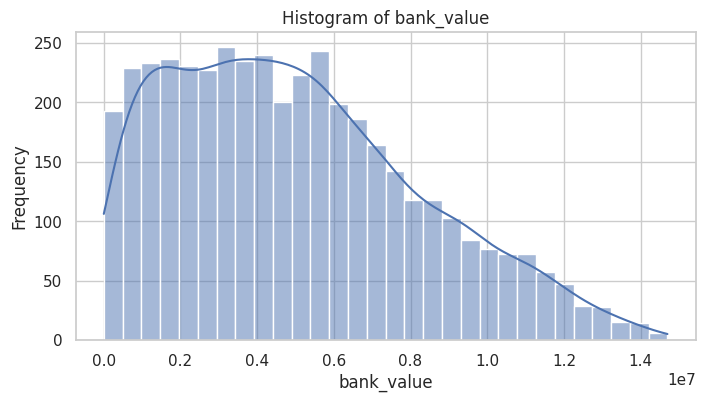

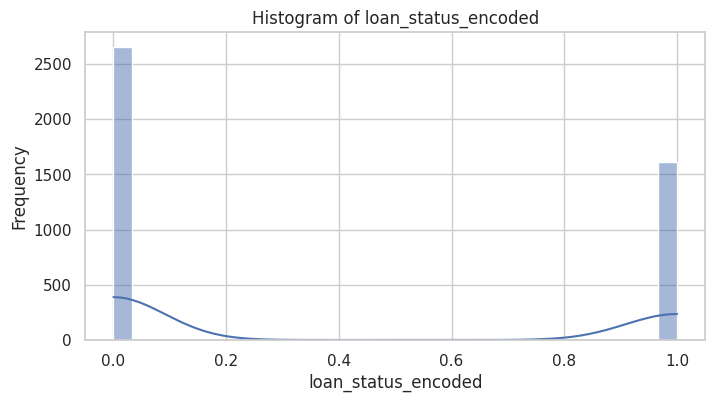

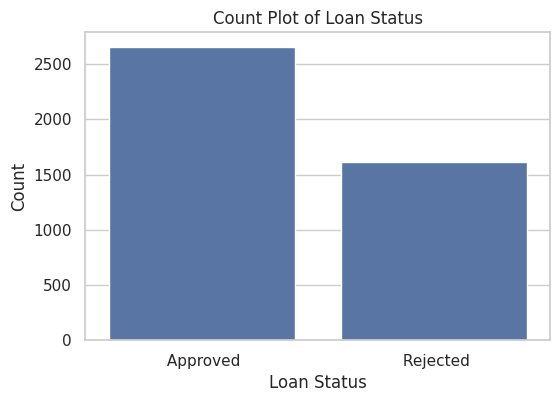

In [14]:
# Visualizations for EDA

# Histogram for numeric distribution
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

for col in numeric_cols:
    plt.figure(figsize=(8, 4))
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

# Count plot (Pie Chart style alternative) for target variable 'loan_status'
plt.figure(figsize=(6, 4))
sns.countplot(x='loan_status', data=df)
plt.title('Count Plot of Loan Status')
plt.xlabel('Loan Status')
plt.ylabel('Count')
plt.show()

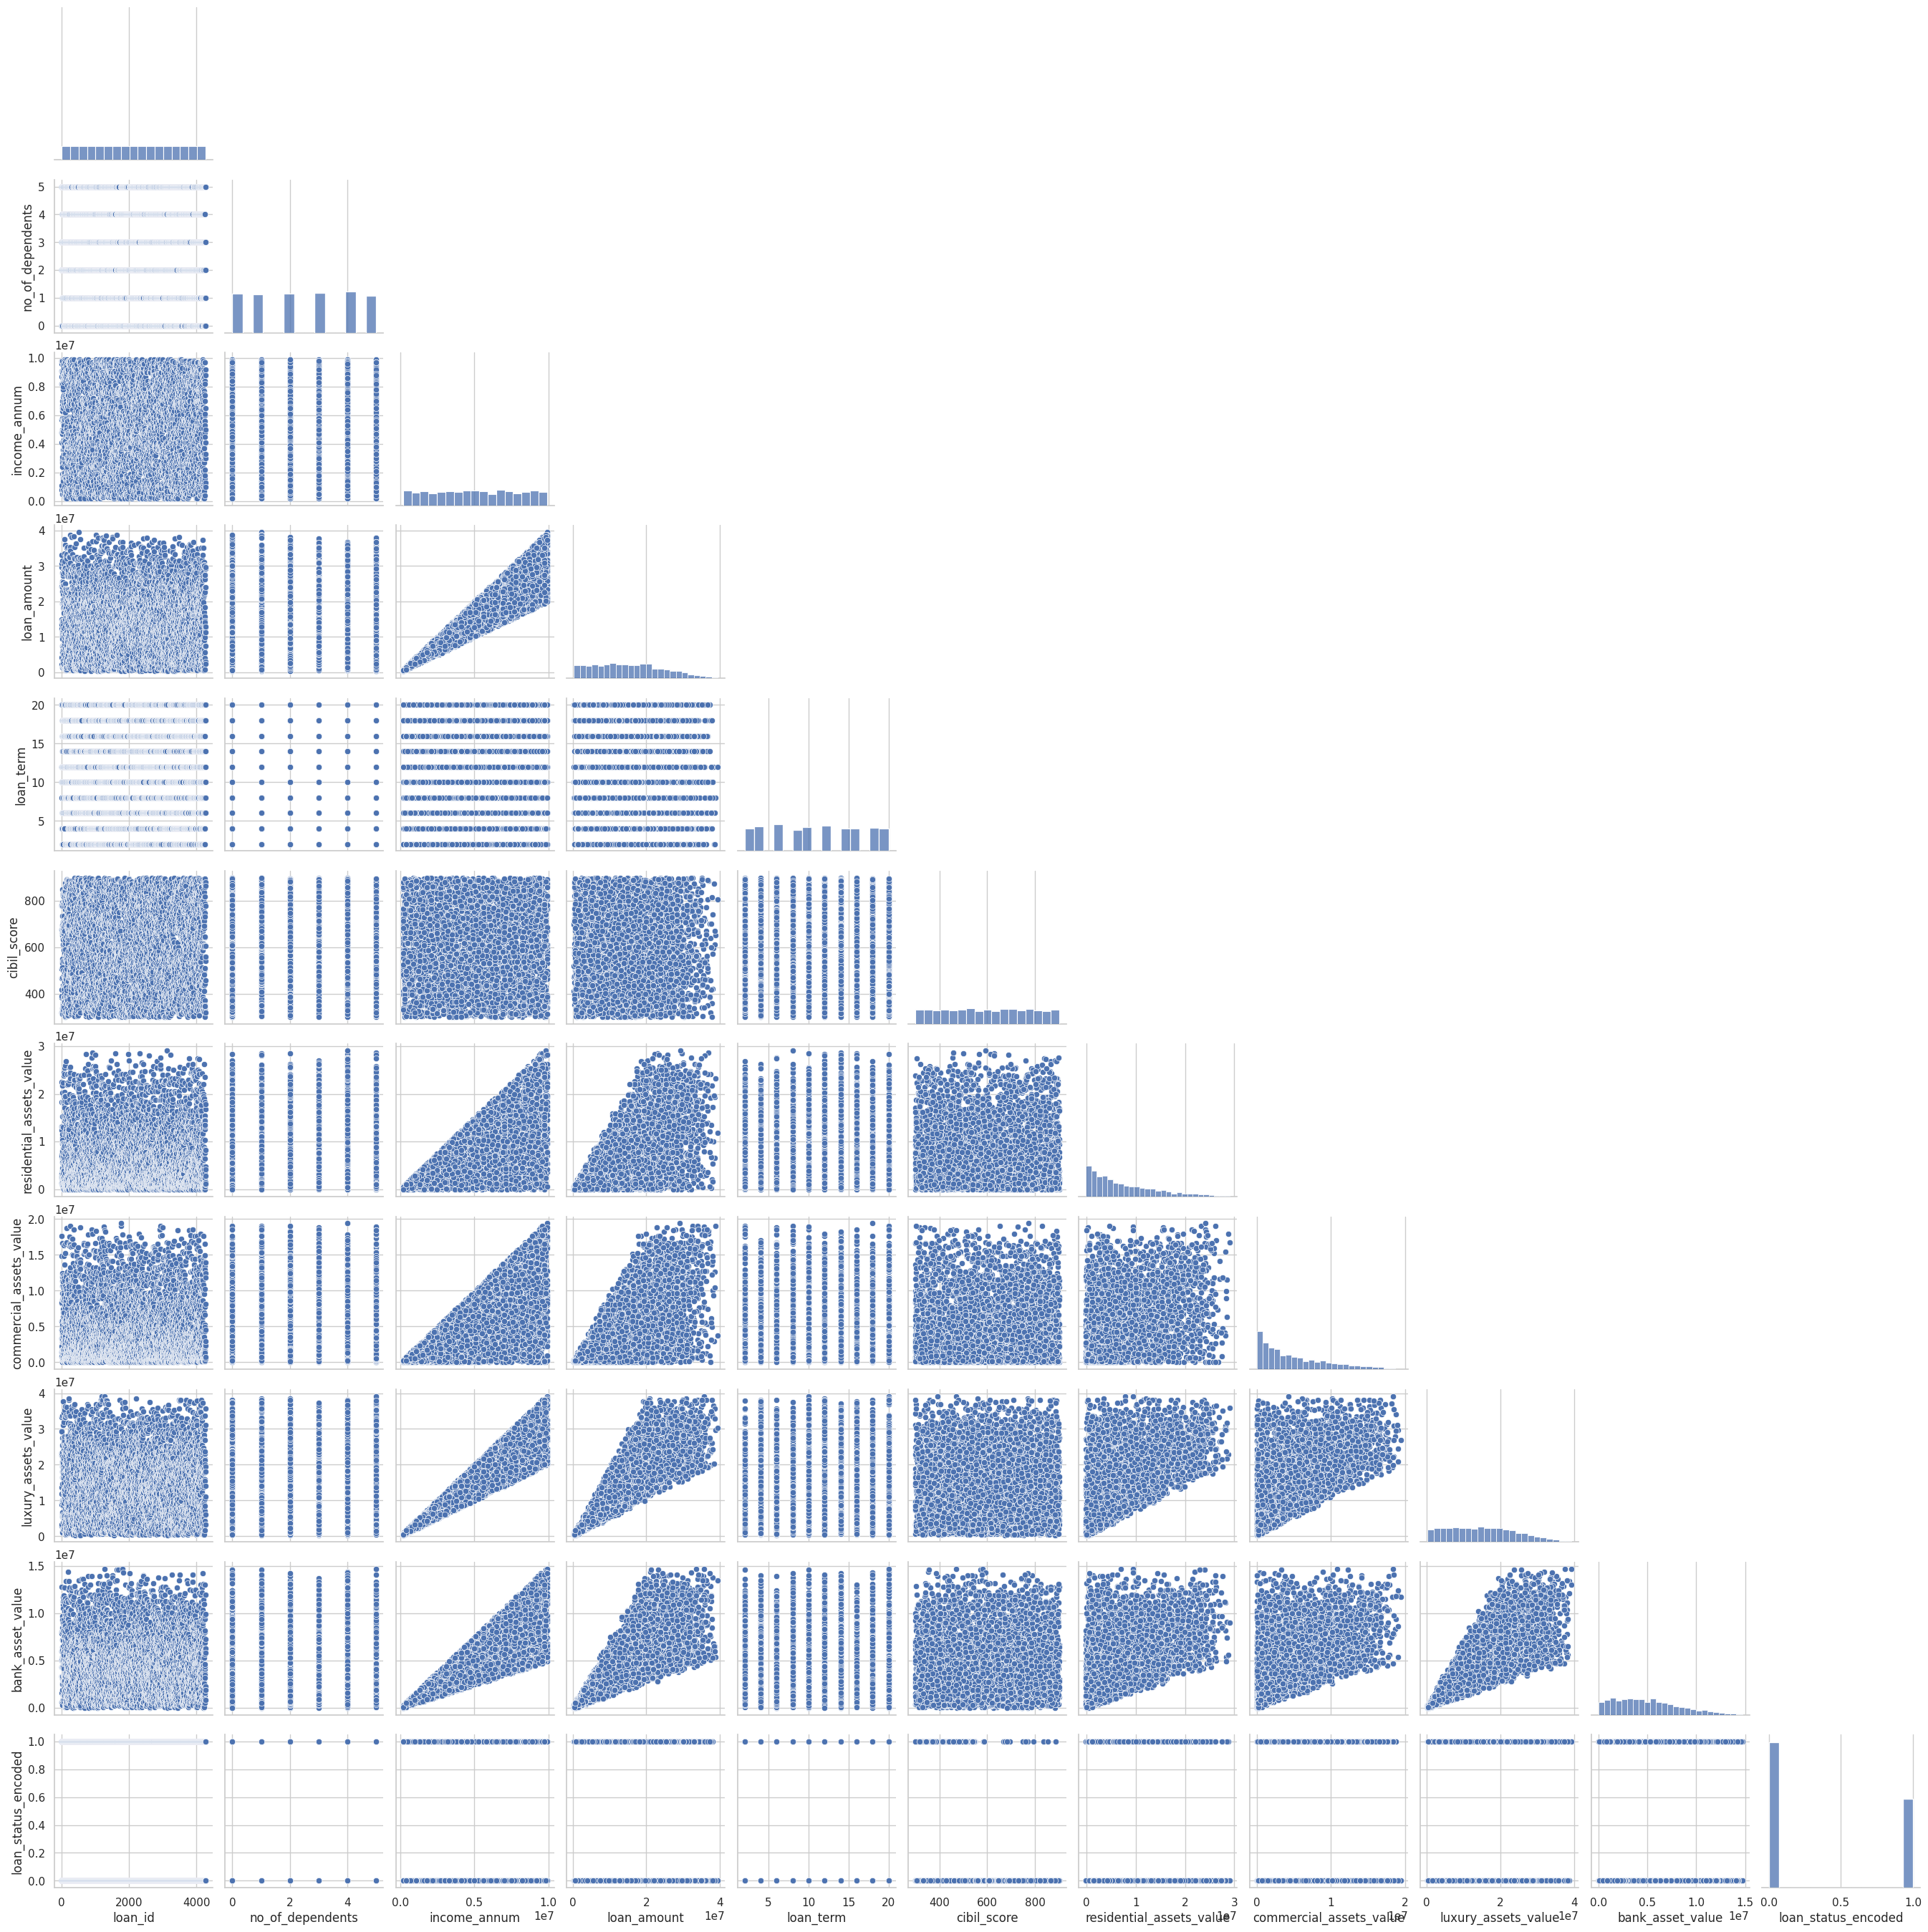

In [6]:
# Pair Plot for a subset of important numerical columns and the target
cols_for_pairplot = numeric_cols.copy()
# Ensuring that the target is considered in the pairplot if encoded
if 'loan_status' in df.columns:
    df['loan_status_encoded'] = pd.factorize(df['loan_status'])[0]
    cols_for_pairplot.append('loan_status_encoded')

sns.pairplot(df[cols_for_pairplot].dropna(), corner=True, diag_kind='hist')
plt.show()

In [7]:
# Rename columns: strip extra spaces from column names
df.columns = df.columns.str.strip()

# Optional: Rename columns to more convenient names
df.rename(columns={
    'no_of_dependents': 'dependents',
    'education': 'education',
    'self_employed': 'self_employed',
    'income_annum': 'income_annual',
    'loan_amount': 'loan_amount',
    'loan_term': 'loan_term',
    'cibil_score': 'cibil_score',
    'residential_assets_value': 'residential_value',
    'commercial_assets_value': 'commercial_value',
    'luxury_assets_value': 'luxury_value',
    'bank_asset_value': 'bank_value',
    'loan_status': 'loan_status'
}, inplace=True)

# Check again for missing values
print('Missing values after renaming:')
print(df.isnull().sum())

# Handle missing values if any (this is a simplistic approach)
df.fillna(method='ffill', inplace=True)

print('Missing values after imputation:')
print(df.isnull().sum())

Missing values after renaming:
loan_id                0
dependents             0
education              0
self_employed          0
income_annual          0
loan_amount            0
loan_term              0
cibil_score            0
residential_value      0
commercial_value       0
luxury_value           0
bank_value             0
loan_status            0
loan_status_encoded    0
dtype: int64
Missing values after imputation:
loan_id                0
dependents             0
education              0
self_employed          0
income_annual          0
loan_amount            0
loan_term              0
cibil_score            0
residential_value      0
commercial_value       0
luxury_value           0
bank_value             0
loan_status            0
loan_status_encoded    0
dtype: int64


In [8]:
#Feature Engineering

# For our predictor, we need to convert categorical columns to numeric.
# Let's check which columns are object type
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
print('Categorical columns:', categorical_cols)

# We must exclude the target variable from encoding if we want to handle it separately
categorical_cols = [col for col in categorical_cols if col != 'loan_status']

# One-hot encoding for categorical features
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

print('Data shape after one-hot encoding:', df_encoded.shape)

Categorical columns: ['education', 'self_employed', 'loan_status']
Data shape after one-hot encoding: (4269, 14)


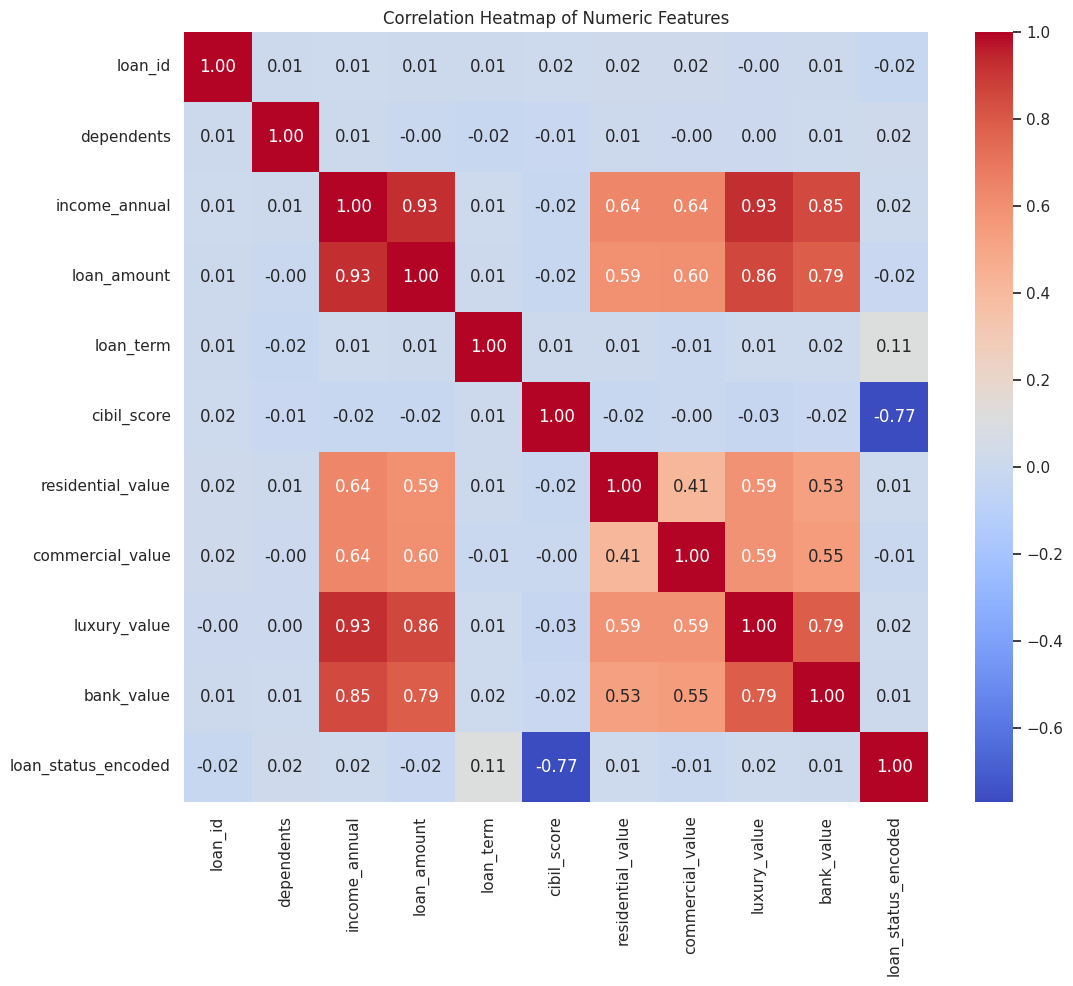

In [9]:
#Correlaton analysis

# Use only numeric columns for correlation heatmap
numeric_df = df_encoded.select_dtypes(include=[np.number])

if numeric_df.shape[1] >= 4:
    plt.figure(figsize=(12, 10))
    correlation_matrix = numeric_df.corr()
    sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm')
    plt.title('Correlation Heatmap of Numeric Features')
    plt.show()
else:
    print('Not enough numeric columns for a meaningful heatmap.')

In [10]:
#Predictor Creation and Evaluation

# Prepare features and target for prediction

# The target variable is 'loan_status'. We will encode it as binary (e.g., Approved=1, Not Approved=0).
df_encoded['loan_status_encoded'] = pd.factorize(df_encoded['loan_status'])[0]

# Drop columns that will not be used for prediction
# For instance, 'loan_id' is nominal and not useful
if 'loan_id' in df_encoded.columns:
    df_encoded.drop(columns=['loan_id'], inplace=True)

# Also drop the original 'loan_status' to keep only encoded target
df_encoded.drop(columns=['loan_status'], inplace=True)

# Define feature set X and target y
X = df_encoded.drop(columns=['loan_status_encoded'])
y = df_encoded['loan_status_encoded']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print('Training Feature Shape:', X_train.shape)
print('Testing Feature Shape:', X_test.shape)

# Create a logistic regression predictor
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate accuracy score
acc = accuracy_score(y_test, y_pred)
print(f'Accuracy Score: {acc:.2f}')

Training Feature Shape: (3415, 11)
Testing Feature Shape: (854, 11)
Accuracy Score: 0.80


Training Feature Shape: (3415, 11)
Testing Feature Shape: (854, 11)

Performing GridSearchCV for Logistic Regression...
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best parameters for Logistic Regression:
{'classifier': LogisticRegression(max_iter=1000, random_state=42), 'classifier__C': 0.01, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
Best cross-validation score: 0.9335

Logistic Regression Results:
Accuracy Score: 0.9520

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.95      0.96       531
           1       0.92      0.96      0.94       323

    accuracy                           0.95       854
   macro avg       0.95      0.95      0.95       854
weighted avg       0.95      0.95      0.95       854



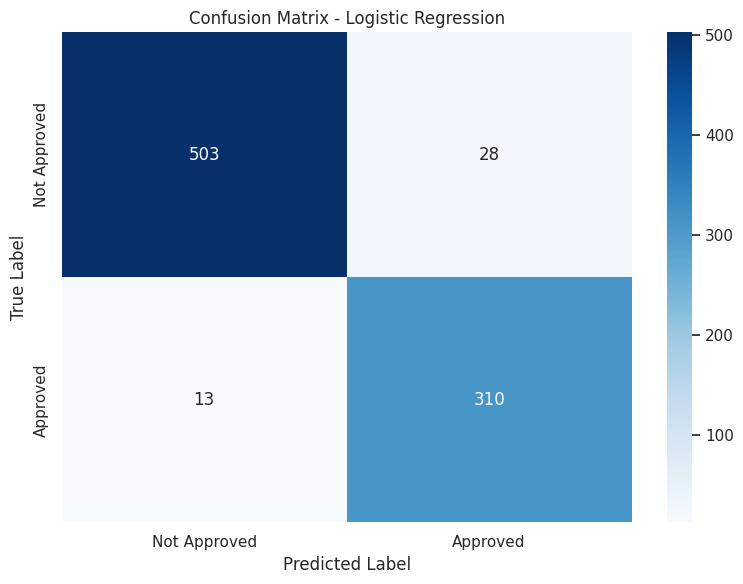

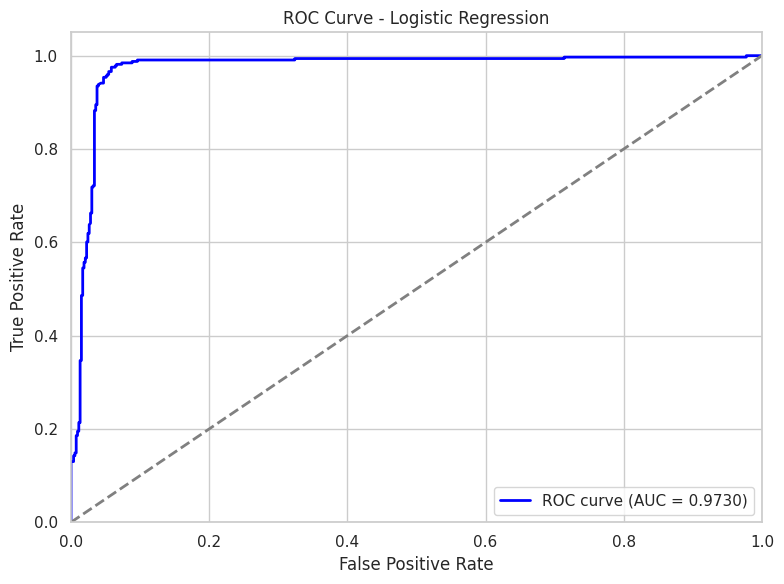


Performing GridSearchCV for Random Forest...
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best parameters for Random Forest:
{'classifier': RandomForestClassifier(random_state=42), 'classifier__class_weight': None, 'classifier__max_depth': None, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200}
Best cross-validation score: 0.9836

Random Forest Results:
Accuracy Score: 0.9836

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       531
           1       0.99      0.97      0.98       323

    accuracy                           0.98       854
   macro avg       0.99      0.98      0.98       854
weighted avg       0.98      0.98      0.98       854



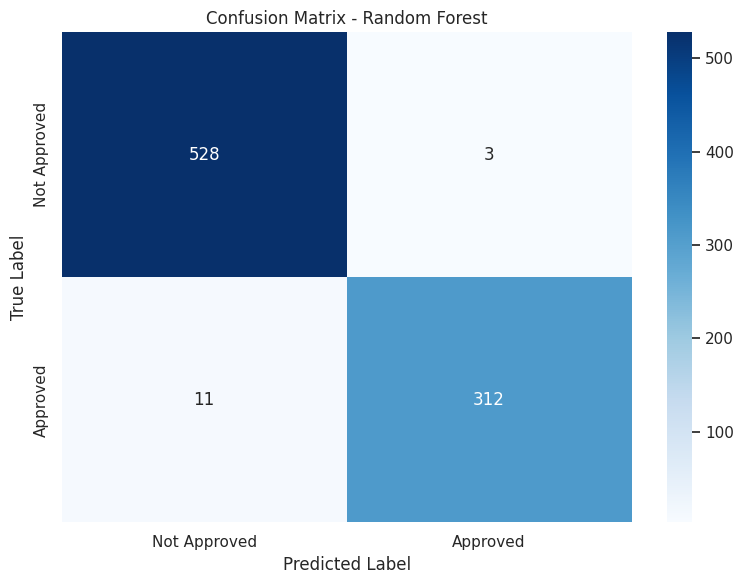

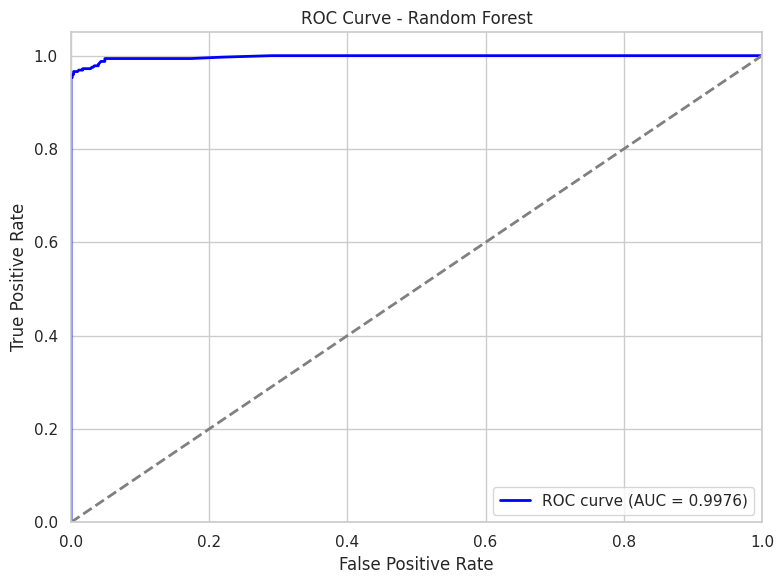


Performing GridSearchCV for Gradient Boosting...
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters for Gradient Boosting:
{'classifier': GradientBoostingClassifier(random_state=42), 'classifier__learning_rate': 0.1, 'classifier__max_depth': 7, 'classifier__n_estimators': 50, 'classifier__subsample': 0.8}
Best cross-validation score: 0.9874

Gradient Boosting Results:
Accuracy Score: 0.9836

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       531
           1       0.98      0.97      0.98       323

    accuracy                           0.98       854
   macro avg       0.98      0.98      0.98       854
weighted avg       0.98      0.98      0.98       854



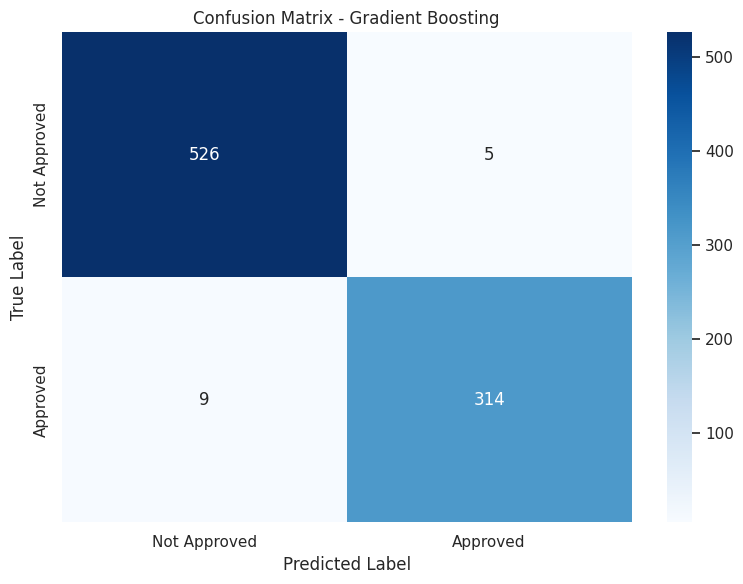

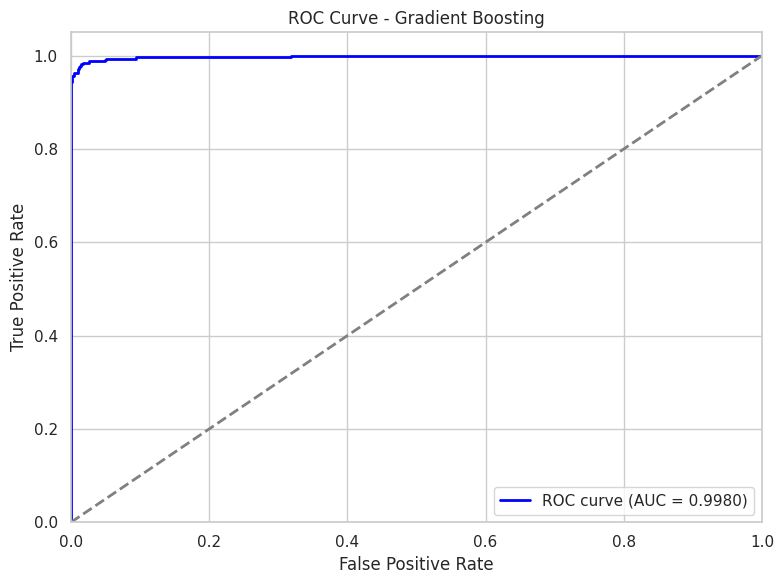


Performing GridSearchCV for SVM...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters for SVM:
{'classifier': SVC(probability=True, random_state=42), 'classifier__C': 10.0, 'classifier__gamma': 'scale', 'classifier__kernel': 'rbf'}
Best cross-validation score: 0.9408

SVM Results:
Accuracy Score: 0.9461

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       531
           1       0.95      0.91      0.93       323

    accuracy                           0.95       854
   macro avg       0.95      0.94      0.94       854
weighted avg       0.95      0.95      0.95       854



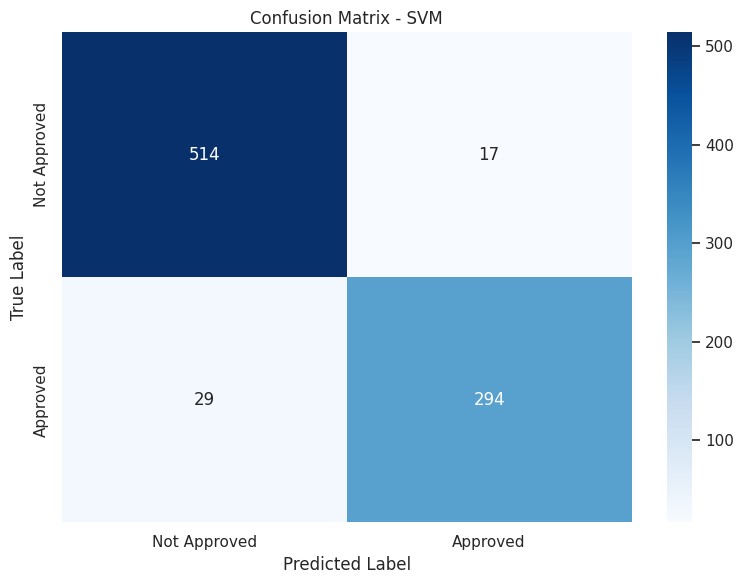

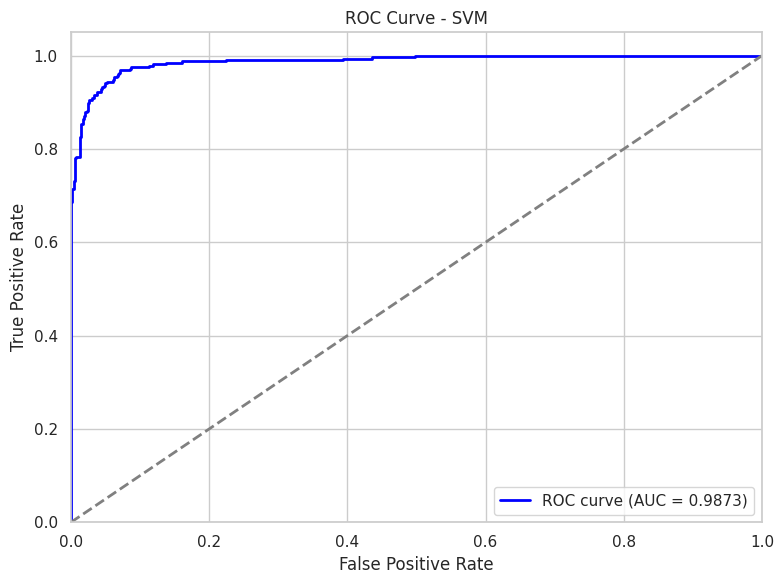


Best Overall Model: Random Forest
Best Test Accuracy: 0.9836


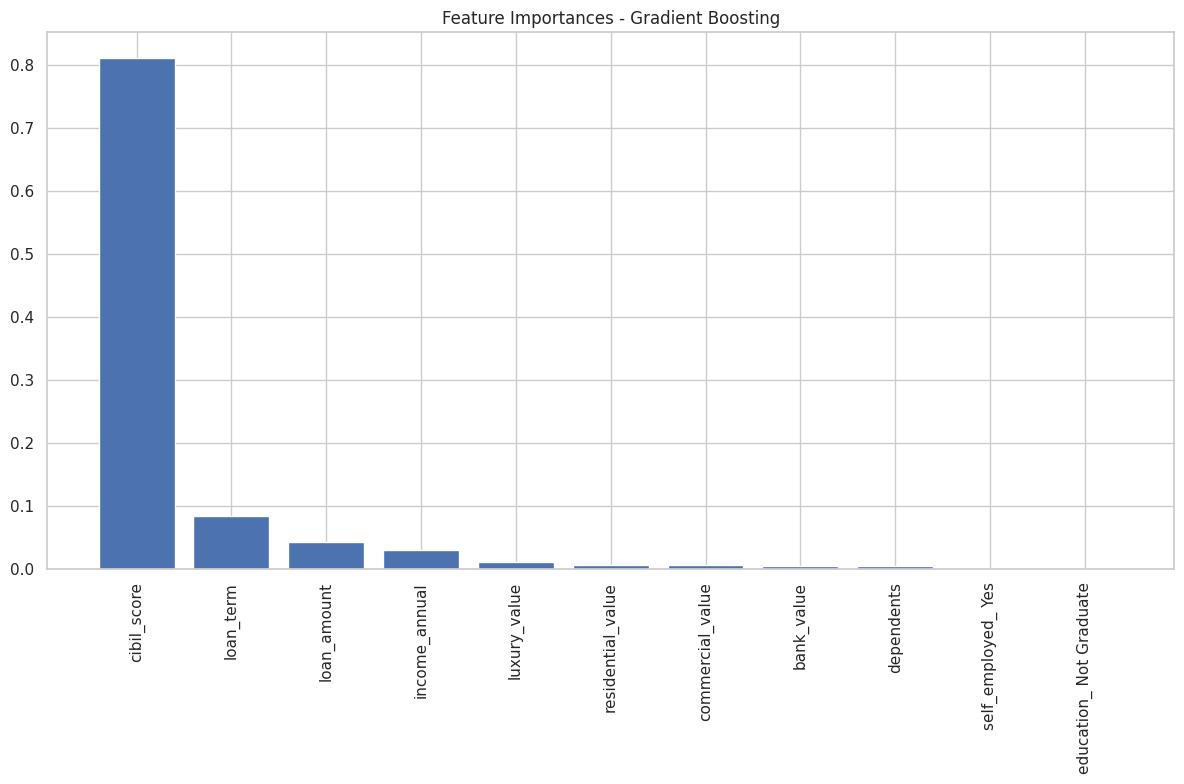


Top 10 Important Features:
1. cibil_score: 0.8113
2. loan_term: 0.0833
3. loan_amount: 0.0418
4. income_annual: 0.0305
5. luxury_value: 0.0105
6. residential_value: 0.0065
7. commercial_value: 0.0064
8. bank_value: 0.0046
9. dependents: 0.0038
10. self_employed_ Yes: 0.0009

DETAILED MODEL COMPARISON

Model Performance Comparison:
              Model  Test Accuracy  CV Accuracy
      Random Forest       0.983607     0.983602
  Gradient Boosting       0.983607     0.987408
Logistic Regression       0.951991     0.933529
                SVM       0.946136     0.940849

BEST MODEL DETAILS: Random Forest

Best parameters:
{'memory': None, 'steps': [('scaler', StandardScaler()), ('classifier', RandomForestClassifier(n_estimators=200, random_state=42))], 'transform_input': None, 'verbose': False, 'scaler': StandardScaler(), 'classifier': RandomForestClassifier(n_estimators=200, random_state=42), 'scaler__copy': True, 'scaler__with_mean': True, 'scaler__with_std': True, 'classifier__bootstra

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')

# Assuming df_encoded is already prepared with features and target
# If not available, you would need to prepare your data first

# Define feature set X and target y
X = df_encoded.drop(columns=['loan_status_encoded'])
y = df_encoded['loan_status_encoded']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print('Training Feature Shape:', X_train.shape)
print('Testing Feature Shape:', X_test.shape)

# Create a function to evaluate and display model results
def evaluate_model(model, X_test, y_test, model_name):
    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)

    # Display results
    print(f"\n{model_name} Results:")
    print(f"Accuracy Score: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Not Approved', 'Approved'],
                yticklabels=['Not Approved', 'Approved'])
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

    # Plot ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()

    # Return model accuracy for comparison
    return accuracy

# Create feature scaling pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', None)  # Placeholder for the classifier
])

# Define models to evaluate
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'SVM': SVC(probability=True, random_state=42)
}

# Set up parameter grids for each model
param_grids = {
    'Logistic Regression': {
        'classifier': [LogisticRegression(random_state=42, max_iter=1000)],
        'classifier__C': [0.01, 0.1, 1.0, 10.0, 100.0],
        'classifier__penalty': ['l1', 'l2', 'elasticnet', None],
        'classifier__solver': ['liblinear', 'saga']
    },
    'Random Forest': {
        'classifier': [RandomForestClassifier(random_state=42)],
        'classifier__n_estimators': [50, 100, 200],
        'classifier__max_depth': [None, 10, 20, 30],
        'classifier__min_samples_split': [2, 5, 10],
        'classifier__min_samples_leaf': [1, 2, 4],
        'classifier__class_weight': [None, 'balanced']
    },
    'Gradient Boosting': {
        'classifier': [GradientBoostingClassifier(random_state=42)],
        'classifier__n_estimators': [50, 100, 200],
        'classifier__learning_rate': [0.01, 0.05, 0.1, 0.2],
        'classifier__max_depth': [3, 5, 7],
        'classifier__subsample': [0.8, 0.9, 1.0]
    },
    'SVM': {
        'classifier': [SVC(probability=True, random_state=42)],
        'classifier__C': [0.1, 1.0, 10.0],
        'classifier__kernel': ['linear', 'rbf', 'poly'],
        'classifier__gamma': ['scale', 'auto', 0.1, 0.01]
    }
}

# Define the scoring metrics to use
scoring = 'accuracy'

# Define cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Dictionary to store best models
best_models = {}
model_scores = {}

# Perform GridSearchCV for each model
for model_name, base_model in models.items():
    print(f"\nPerforming GridSearchCV for {model_name}...")

    # Get parameter grid for current model
    param_grid = param_grids[model_name]

    # Create GridSearchCV
    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        scoring=scoring,
        cv=cv,
        n_jobs=-1,  # Use all available cores
        verbose=1
    )

    # Fit the grid search
    grid_search.fit(X_train, y_train)

    # Store best model
    best_models[model_name] = grid_search.best_estimator_

    # Print best parameters
    print(f"Best parameters for {model_name}:")
    print(grid_search.best_params_)
    print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

    # Evaluate the model on test set
    model_scores[model_name] = evaluate_model(grid_search.best_estimator_, X_test, y_test, model_name)

# Find the best overall model
best_model_name = max(model_scores, key=model_scores.get)
best_model = best_models[best_model_name]

print("\n" + "="*50)
print(f"Best Overall Model: {best_model_name}")
print(f"Best Test Accuracy: {model_scores[best_model_name]:.4f}")
print("="*50)

# Feature importance analysis for tree-based models
if 'Random Forest' in best_models or 'Gradient Boosting' in best_models:
    best_tree_model_name = 'Random Forest' if model_scores.get('Random Forest', 0) > model_scores.get('Gradient Boosting', 0) else 'Gradient Boosting'
    best_tree_model = best_models[best_tree_model_name]

    # Get feature importances
    if best_tree_model_name in ['Random Forest', 'Gradient Boosting']:
        feature_importances = best_tree_model.named_steps['classifier'].feature_importances_
        features = X.columns

        # Sort features by importance
        indices = np.argsort(feature_importances)[::-1]

        # Plot feature importances
        plt.figure(figsize=(12, 8))
        plt.title(f'Feature Importances - {best_tree_model_name}')
        plt.bar(range(len(indices)), feature_importances[indices], align='center')
        plt.xticks(range(len(indices)), [features[i] for i in indices], rotation=90)
        plt.tight_layout()
        plt.show()

        # Print top 10 features
        print("\nTop 10 Important Features:")
        for i, idx in enumerate(indices[:10]):
            print(f"{i+1}. {features[idx]}: {feature_importances[idx]:.4f}")

# Print detailed information about all models
print("\n" + "="*80)
print("DETAILED MODEL COMPARISON")
print("="*80)

# Create a comparison dataframe
comparison_results = pd.DataFrame({
    'Model': list(model_scores.keys()),
    'Test Accuracy': list(model_scores.values())
}).sort_values(by='Test Accuracy', ascending=False)

# Add cross-validation scores
cv_scores = {}
for model_name, model in best_models.items():
    cv_scores[model_name] = cross_val_score(model, X_train, y_train, cv=cv, scoring=scoring).mean()

comparison_results['CV Accuracy'] = comparison_results['Model'].map(cv_scores)

# Print comparison table
print("\nModel Performance Comparison:")
print(comparison_results.to_string(index=False))

# Print best model details
print("\n" + "="*80)
print(f"BEST MODEL DETAILS: {best_model_name}")
print("="*80)
print(f"\nBest parameters:")
print(best_model.get_params())

# If the best model is a tree-based model, print feature importances
if best_model_name in ['Random Forest', 'Gradient Boosting']:
    print("\nFeature Importances:")
    importances = best_model.named_steps['classifier'].feature_importances_
    features = X.columns
    feature_importance_df = pd.DataFrame({
        'Feature': features,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)
    print(feature_importance_df.to_string(index=False))

# For logistic regression, print coefficients
elif best_model_name == 'Logistic Regression':
    print("\nFeature Coefficients:")
    coefficients = best_model.named_steps['classifier'].coef_[0]
    features = X.columns
    coef_df = pd.DataFrame({
        'Feature': features,
        'Coefficient': coefficients
    }).sort_values(by='Coefficient', ascending=False)
    print(coef_df.to_string(index=False))

# Print classification report for best model
print("\nDetailed Classification Report for Best Model:")
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))

# Save the best model
import joblib
joblib.dump(best_model, 'best_loan_approval_model.pkl')
print("\nBest model saved as 'best_loan_approval_model.pkl'")

# Save the comparison results to CSV for reference
comparison_results.to_csv('model_comparison_results.csv', index=False)
print("Model comparison results saved to 'model_comparison_results.csv'")

# Function to load and examine the saved model
print("\n" + "="*80)
print("HOW TO LOAD AND USE THE SAVED MODEL")
print("="*80)
print("""
# To load and use the saved model in the future:
import joblib

# Load the model
loaded_model = joblib.load('best_loan_approval_model.pkl')

# Use the model to make predictions
new_predictions = loaded_model.predict(X_new)

# To get prediction probabilities
prediction_probabilities = loaded_model.predict_proba(X_new)
""")

Training Feature Shape: (3415, 11)
Testing Feature Shape: (854, 11)

Model Evaluation:
Accuracy: 0.9836065573770492

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       531
           1       0.99      0.97      0.98       323

    accuracy                           0.98       854
   macro avg       0.99      0.98      0.98       854
weighted avg       0.98      0.98      0.98       854



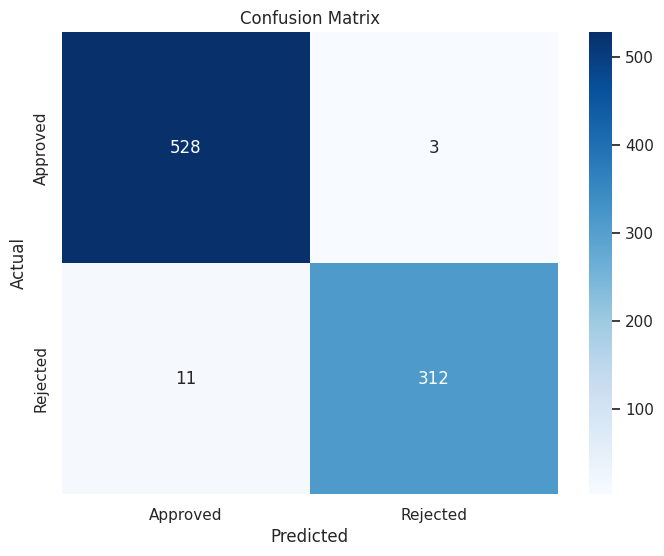

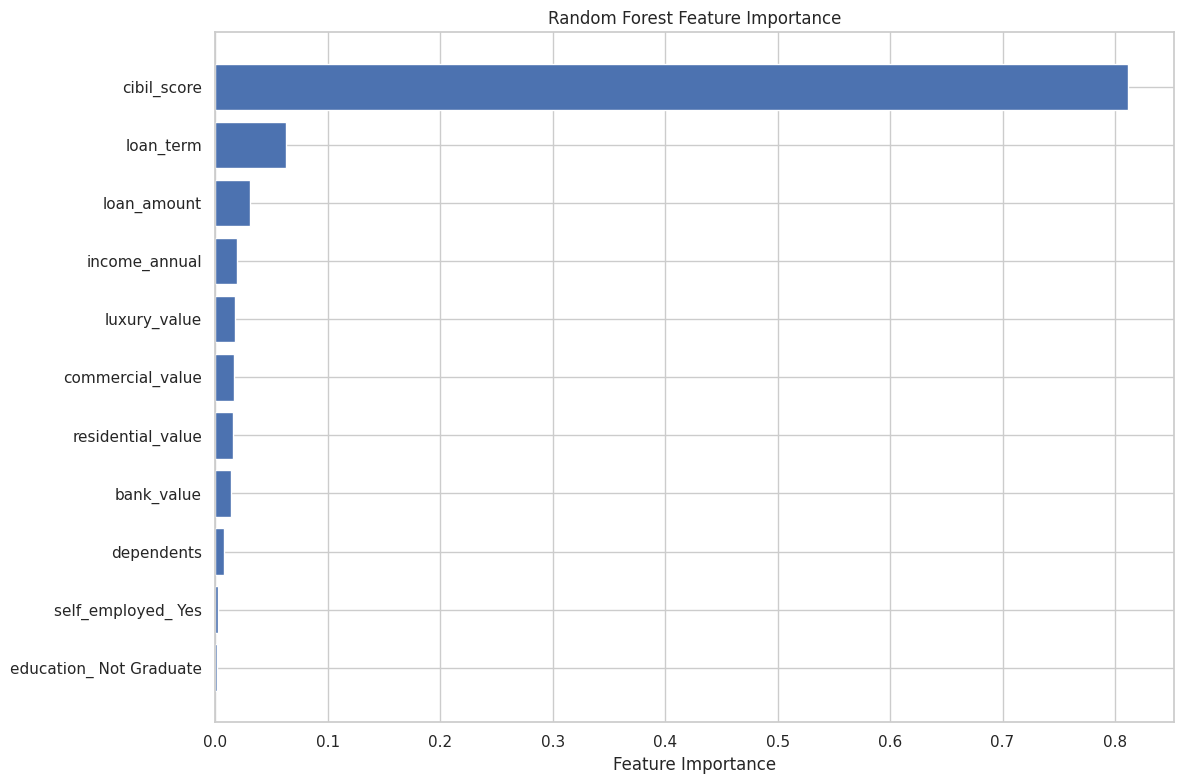

Model saved as 'loan_prediction_model.pkl'


In [25]:

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print('Training Feature Shape:', X_train.shape)
print('Testing Feature Shape:', X_test.shape)

# Create a pipeline with the best parameters found
best_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(
        n_estimators=200,
        random_state=42,
        criterion='gini',
        max_features='sqrt'
    ))
])

# Train the model
best_pipeline.fit(X_train, y_train)

# Make predictions
y_pred = best_pipeline.predict(X_test)
y_pred_proba = best_pipeline.predict_proba(X_test)

# Evaluate the model
print("\nModel Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Approved', 'Rejected'],
            yticklabels=['Approved', 'Rejected'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Feature Importance
feature_importance = best_pipeline.named_steps['classifier'].feature_importances_
feature_names = X.columns
sorted_idx = np.argsort(feature_importance)

plt.figure(figsize=(12, 8))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
plt.xlabel('Feature Importance')
plt.title('Random Forest Feature Importance')
plt.tight_layout()
plt.show()

# Save the model
import joblib
joblib.dump(best_pipeline, 'loan_prediction_model.pkl')
print("Model saved as 'loan_prediction_model.pkl'")

# Function to make predictions on new data
def predict_loan_status(new_data):
    """
    Make predictions on new loan applications

    Parameters:
    new_data (DataFrame): Preprocessed data with the same columns as training data

    Returns:
    DataFrame: Original data with prediction and probability columns
    """
    # Make sure new_data has the same columns as training data
    required_columns = X.columns
    missing_columns = set(required_columns) - set(new_data.columns)

    if missing_columns:
        raise ValueError(f"New data is missing these columns: {missing_columns}")

    # Make predictions
    predictions = best_pipeline.predict(new_data[required_columns])
    probabilities = best_pipeline.predict_proba(new_data[required_columns])

    # Add predictions to the original data
    result = new_data.copy()
    result['predicted_status'] = predictions
    result['predicted_status_label'] = ['Approved' if p == 0 else 'Rejected' for p in predictions]
    result['approval_probability'] = probabilities[:, 0]  # Probability of being approved

    return result

# Example of how to use the model for prediction
def predict_for_new_applicant(income_annual, loan_amount, loan_term, cibil_score, residential_value,
                              commercial_value, luxury_value, bank_value, **other_features):
    """
    Predict loan status for a new applicant

    Returns:
    dict: Prediction results including status and probability
    """
    # Create a DataFrame with the applicant's information
    applicant_data = pd.DataFrame({
        'income_annual': [income_annual],
        'loan_amount': [loan_amount],
        'loan_term': [loan_term],
        'cibil_score': [cibil_score],
        'residential_value': [residential_value],
        'commercial_value': [commercial_value],
        'luxury_value': [luxury_value],
        'bank_value': [bank_value],
        **{k: [v] for k, v in other_features.items()}
    })

    # If the original dataset had other columns, they need to be included here

    # Make prediction
    result = predict_loan_status(applicant_data)

    # Return the prediction in a more readable format
    return {
        'prediction': result['predicted_status_label'].iloc[0],
        'approval_probability': f"{result['approval_probability'].iloc[0]:.2%}",
        'rejection_probability': f"{(1 - result['approval_probability'].iloc[0]):.2%}"
    }

# Example usage
# prediction = predict_for_new_applicant(
#     income_annual=8500000,
#     loan_amount=25000000,
#     loan_term=15,
#     cibil_score=720,
#     residential_value=18000000,
#     commercial_value=5000000,
#     luxury_value=20000000,
#     bank_value=7000000
# )
# print(prediction)